## Step 1: Load the necessary libraries

In [1]:
import matplotlib.pyplot
import numpy as np
import h5py

Setting the variables to pull the data and labels out of the HDF5 file

In [2]:
data = 'matrix_of_128'
labels = 'labels_for_128'

Opening a "synthetic_data.h5" file

In [3]:
handle = h5py.File('synthetic_data.h5', 'r')

Converting the matrices part of the handle to a NumPy set of matrices

In [4]:
matrices = np.array(handle[data])

Pulling the first matrix off the stack of matrices

In [5]:
testMatrix = matrices[:,:,0]

Plotting the spy plot to see the block structure

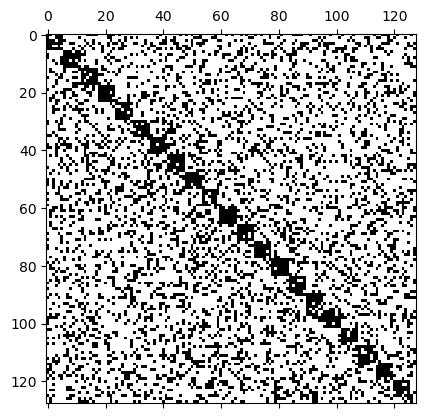

In [8]:
matplotlib.pyplot.spy(testMatrix)
matplotlib.pyplot.show()

Grabbing the corresponding labels

In [10]:
blockSizes = np.array(handle[labels])
testBlockSizes = blockSizes[:,0]

Now we're going to import the modules needed to actually solve the system.

**Note**: by "solve" the system, we are going to try and solve the equation

$ Ax = b $

Where $A$ is the matrix we pulled out of the synthetic data set, $x$ is what we're solving for, and $b$ isn't too important for us, so we'll initialize it to all 1's in this step as well.



In [12]:
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator

b = np.ones(testMatrix.shape[0])

Creating a callback class to better monitor residual progression

In [13]:
class GMRESCallback:
    """
    Callback class for monitoring GMRES convergence.
    Records the residual values provided directly by GMRES.
    """
    def __init__(self):
        """
        Initialize the callback to store convergence history.
        """
        self.residuals: List[float] = []
        self.iterations: int = 0
        
    def __call__(self, residual_norm: float) -> None:
        """
        Called by GMRES after each iteration with the residual norm.
        
        Args:
            residual_norm: The norm of the current residual, provided by GMRES
        """
        # The input is already the residual norm - no need to compute it
        self.residuals.append(float(residual_norm))
        self.iterations += 1
        
        # Optional: Print progress
        print(f"Iteration {self.iterations}: residual = {residual_norm:.2e}")

Initializing the callback class

In [15]:
callback = GMRESCallback()

And now we can "solve" the system

*Solve is in quotes here since we're probably not going be able to find a solution to a random matrix*

In [16]:
x, info = gmres(testMatrix, b,
                callback=callback, # Tag along the callback
                tol=1e-5,           # Convergence tolerance
                maxiter=1000,       # Maximum iterations
                restart=20,         # Restart parameter
                atol=1e-8)         # Absolute tolerance

Iteration 1: residual = 1.30e-01
Iteration 2: residual = 1.29e-01
Iteration 3: residual = 1.28e-01
Iteration 4: residual = 1.28e-01
Iteration 5: residual = 1.24e-01
Iteration 6: residual = 1.24e-01
Iteration 7: residual = 1.24e-01
Iteration 8: residual = 1.23e-01
Iteration 9: residual = 1.23e-01
Iteration 10: residual = 1.23e-01
Iteration 11: residual = 1.22e-01
Iteration 12: residual = 1.21e-01
Iteration 13: residual = 1.21e-01
Iteration 14: residual = 1.21e-01
Iteration 15: residual = 1.20e-01
Iteration 16: residual = 1.19e-01
Iteration 17: residual = 1.19e-01
Iteration 18: residual = 1.19e-01
Iteration 19: residual = 1.19e-01
Iteration 20: residual = 1.19e-01
Iteration 21: residual = 1.19e-01
Iteration 22: residual = 1.19e-01
Iteration 23: residual = 1.19e-01
Iteration 24: residual = 1.19e-01
Iteration 25: residual = 1.19e-01
Iteration 26: residual = 1.19e-01
Iteration 27: residual = 1.18e-01
Iteration 28: residual = 1.18e-01
Iteration 29: residual = 1.18e-01
Iteration 30: residual 

Plot the residual progression over time

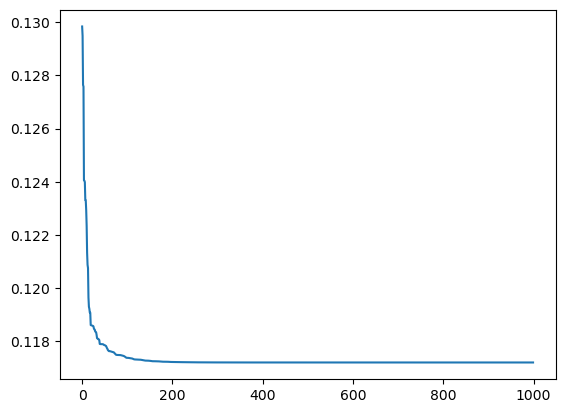

In [18]:
matplotlib.pyplot.plot(callback.residuals)

So we're getting close to a solution pretty quickly, but we still have some decent amount of error.

For reference, application areas where you don't care too much about the quality of the solution might aim for a residual, $r < 10^{-3}$. In more precise areas of science and engineering, it's more common to aim for things like $10^{-6}$ to $10^{-9}$. Our "solution" of $\approx 10^{-1}$ isn't great.

The block size algorithm we're finding is supposed to help us with how well we can solve systems like this. We're going to stick with GMRES as an algorithm, but add one more parameter, M. M is going to represent our "preconditioner". Our preconditioner should help by either:
* Helping us converge to a smaller residual
* Helping us converge to a similar residual more quickly

Choosing the right preconditioner is very difficult.

The thrust of our research (or the reason someone would care about us predicting block sizes well) is to help the user properly configure one of the most common preconditioners for GMRES (or similar matrix solution algorithms).

Unfortunately, SciPy doesn't have a built-in Block Jacobi preconditioner, so we have to write one. This needs to be a thing of class "LinearOperator" from SciPy.

In [19]:
def create_block_jacobi_preconditioner(A, block_size):
    n = A.shape[0]
    
    # Extract and invert diagonal blocks
    blocks = []
    for i in range(0, n, block_size):
        end = min(i + block_size, n)
        block = A[i:end, i:end]
        blocks.append(np.linalg.inv(block))
    
    def matvec(x):
        result = np.zeros_like(x)
        for i, block in enumerate(blocks):
            start = i * block_size
            end = min(start + block_size, n)
            result[start:end] = block @ x[start:end]
        return result
    
    return LinearOperator(A.shape, matvec)

Now, given a matrix and a desired block size, we can find the optimal block size based on the effect on GMRES. Let's create a couple preconditioners.

In [20]:
M1 = create_block_jacobi_preconditioner(testMatrix, block_size=1)
M2 = create_block_jacobi_preconditioner(testMatrix, block_size=2)
M4 = create_block_jacobi_preconditioner(testMatrix, block_size=4)
M6 = create_block_jacobi_preconditioner(testMatrix, block_size=6)
M8 = create_block_jacobi_preconditioner(testMatrix, block_size=8)

LinAlgError: Singular matrix